In [19]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.cluster.hierarchy as shc
import umap
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt


In [2]:
df_eda = pd.read_csv("data/eda_dataset.csv", index_col=0)
df_pca = pd.read_csv("data/pca_dataset.csv", index_col=0)

In [3]:
scaler_viz = MinMaxScaler()
df_viz = pd.DataFrame(scaler_viz.fit_transform(df_eda), columns=df_eda.columns)

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embedding = reducer.fit_transform(df_viz)  # Don't pass ensure_all_finite
df_umap = pd.DataFrame(embedding, columns=['UMAP_X', 'UMAP_Y'], index=df_viz.index)


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


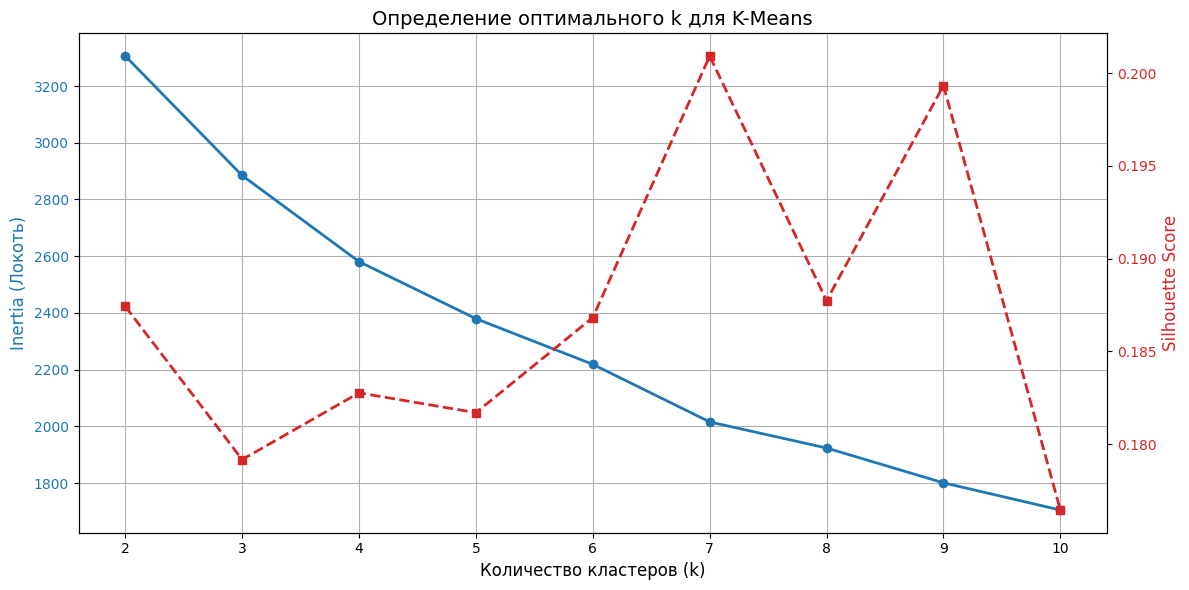

k=2: Silhouette=0.187, Inertia=3305
k=3: Silhouette=0.179, Inertia=2884
k=4: Silhouette=0.183, Inertia=2580
k=5: Silhouette=0.182, Inertia=2379
k=6: Silhouette=0.187, Inertia=2218
k=7: Silhouette=0.201, Inertia=2015
k=8: Silhouette=0.188, Inertia=1923
k=9: Silhouette=0.199, Inertia=1800
k=10: Silhouette=0.176, Inertia=1704


In [ ]:
range_n_clusters = range(2, 11)
inertia = []
silhouette_avg = []

for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(df_pca) # Используем данные после PCA
    inertia.append(kmeans.inertia_)
    silhouette_avg.append(silhouette_score(df_pca, cluster_labels))

fig, ax1 = plt.subplots(figsize=(12, 6))
color = 'tab:blue'
ax1.set_xlabel('Количество кластеров (k)', fontsize=12)
ax1.set_ylabel('Inertia (Локоть)', color=color, fontsize=12)
ax1.plot(range_n_clusters, inertia, 'o-', color=color, linewidth=2, label='Inertia')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Silhouette Score', color=color, fontsize=12)
ax2.plot(range_n_clusters, silhouette_avg, 's--', color=color, linewidth=2, label='Silhouette')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Определение оптимального k для K-Means', fontsize=14)
fig.tight_layout()
plt.show()

# Вывод значений
for k, sil, inert in zip(range_n_clusters, silhouette_avg, inertia):
    print(f"k={k}: Silhouette={sil:.3f}, Inertia={int(inert)}")


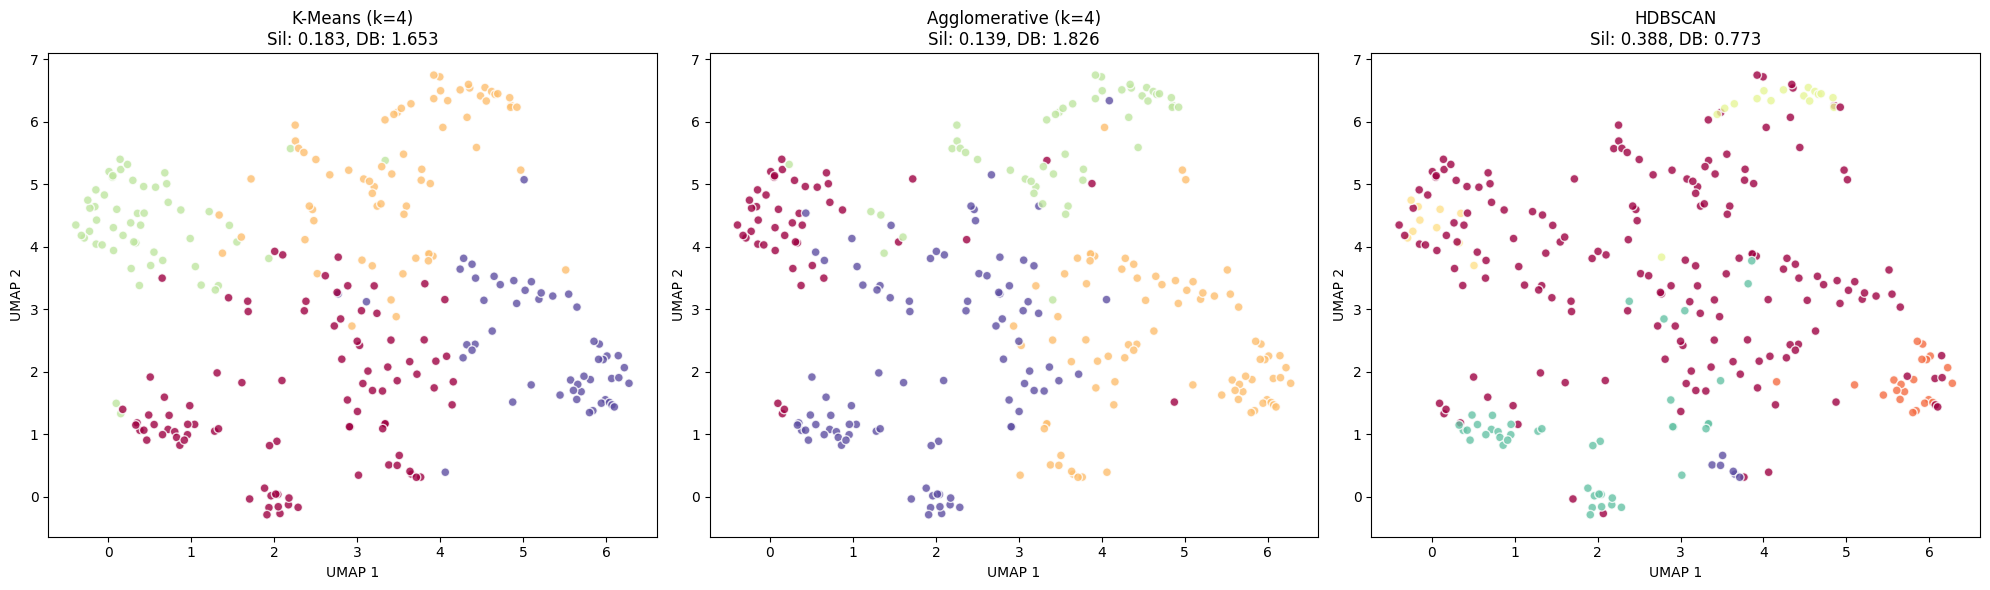


--- Сравнение качества кластеризации ---
                     Silhouette (Max)  Davies-Bouldin (Min)  Clusters
HDBSCAN                         0.388                 0.773       5.0
K-Means (k=4)                   0.183                 1.653       4.0
Agglomerative (k=4)             0.139                 1.826       4.0


In [15]:
from sklearn.cluster import KMeans, AgglomerativeClustering
import hdbscan
from sklearn.metrics import silhouette_score, davies_bouldin_score

# --- Настройка моделей ---
models = {
    "K-Means (k=4)": KMeans(n_clusters=4, random_state=42, n_init=10),
    "Agglomerative (k=4)": AgglomerativeClustering(n_clusters=4),
    "HDBSCAN": hdbscan.HDBSCAN(min_cluster_size=5, min_samples=3)
}

results = {}
labels_dict = {}

# --- Цикл обучения ---
plt.figure(figsize=(20, 6))

for i, (name, model) in enumerate(models.items()):
    # 1. Обучение
    # Для HDBSCAN и Agglomerative используем fit_predict, для KMeans - fit_predict
    labels = model.fit_predict(df_pca) # Обучаем на PCA компонентах!
    labels_dict[name] = labels
    
    # 2. Считаем метрики
    # Важно: для метрик исключаем "Шум" (-1) в HDBSCAN, иначе метрики будут занижены
    if name == "HDBSCAN":
        valid_mask = labels != -1
        if np.sum(valid_mask) > 0: # Если есть хоть один кластер
            sil_score = silhouette_score(df_pca[valid_mask], labels[valid_mask])
            db_score = davies_bouldin_score(df_pca[valid_mask], labels[valid_mask])
            n_clusters_found = len(set(labels)) - 1 # минус шум
        else:
            sil_score, db_score = 0, 0
    else:
        sil_score = silhouette_score(df_pca, labels)
        db_score = davies_bouldin_score(df_pca, labels)
        n_clusters_found = len(set(labels))
        
    results[name] = {
        "Silhouette (Max)": round(sil_score, 3), 
        "Davies-Bouldin (Min)": round(db_score, 3),
        "Clusters": n_clusters_found
    }
    
    # 3. Визуализация на UMAP
    plt.subplot(1, 3, i+1)
    
    # Рисуем точки
    # Сделаем серые точки для шума (если есть)
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    
    scatter = plt.scatter(df_umap['UMAP_X'], df_umap['UMAP_Y'], 
                          c=labels, cmap='Spectral', s=40, alpha=0.8, edgecolors='w')
    
    plt.title(f"{name}\nSil: {results[name]['Silhouette (Max)']}, DB: {results[name]['Davies-Bouldin (Min)']}")
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')

plt.tight_layout()
plt.show()

# --- Вывод сводной таблицы ---
results_df = pd.DataFrame(results).T
print("\n--- Сравнение качества кластеризации ---")
print(results_df.sort_values(by="Silhouette (Max)", ascending=False))


Всего моделей в ансамбле: 19


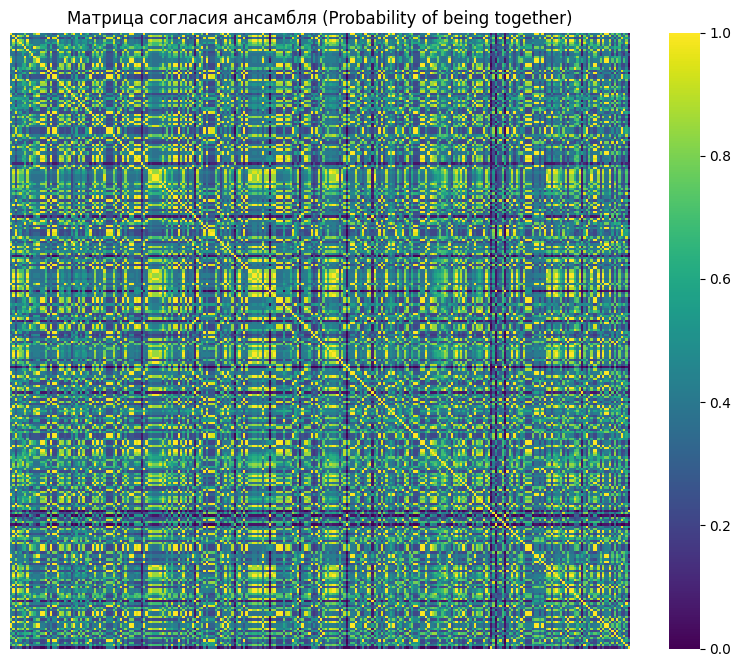

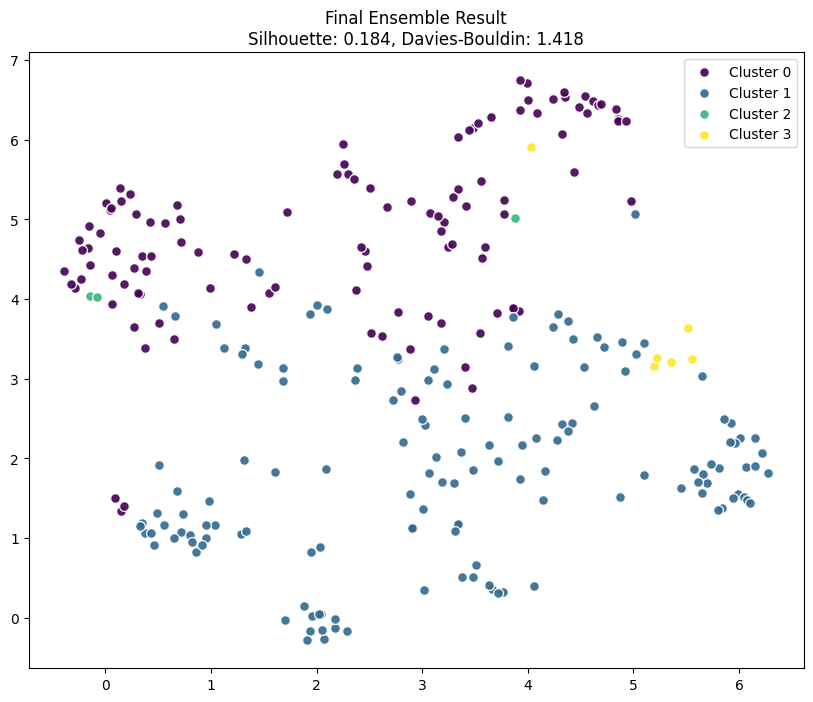


--- Итоговые метрики Ансамбля ---
Silhouette Score: 0.1839
Davies-Bouldin Score: 1.4180


NameError: name 'df_scaled' is not defined

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering
import hdbscan
from sklearn.metrics import silhouette_score, davies_bouldin_score

# --- 1. Обучение базовых моделей (если они еще не обучены в памяти) ---
models = {
    "K-Means (k=4)": KMeans(n_clusters=4, random_state=42, n_init=10),
    "Agglomerative (k=4)": AgglomerativeClustering(n_clusters=4),
    "HDBSCAN": hdbscan.HDBSCAN(min_cluster_size=5, min_samples=3)
}

labels_dict = {}
for name, model in models.items():
    labels_dict[name] = model.fit_predict(df_pca)

# --- 2. Создание АНСАМБЛЯ (Ensemble) ---
# Идея: Строим матрицу совпадений (Co-association matrix)
n_samples = df_pca.shape[0]
co_matrix = np.zeros((n_samples, n_samples))

n_models = 0
for name, labels in labels_dict.items():
    # Для HDBSCAN игнорируем шум (-1) при голосовании, или считаем его отдельным кластером
    # Здесь мы будем считать -1 как обычную метку, чтобы не терять данные
    n_models += 1
    
    # Матрица N x N: 1 если i и j в одном кластере, 0 если нет
    # Быстрый способ через broadcasting
    matrix = (labels[:, None] == labels[None, :]).astype(int)
    co_matrix += matrix

# Нормируем матрицу (получаем вероятность от 0 до 1)
co_matrix /= n_models

# Превращаем вероятность в "расстояние" (чем больше вероятность, тем меньше расстояние)
# 1 - prob
dist_matrix = 1 - co_matrix

# Финальная кластеризация ансамбля (используем Agglomerative на матрице расстояний)
# affinity='precomputed' означает, что мы подаем готовую матрицу расстояний
ensemble_model = AgglomerativeClustering(n_clusters=4, metric='precomputed', linkage='average')
ensemble_labels = ensemble_model.fit_predict(dist_matrix)

# Добавляем Ансамбль в словарь результатов
labels_dict["Ensemble (Voting)"] = ensemble_labels

# --- 3. Сравнение всех 4-х вариантов ---
results_data = []

plt.figure(figsize=(20, 12)) # Увеличим размер, так как теперь 4 графика (2x2)

for i, (name, labels) in enumerate(labels_dict.items()):
    
    # Расчет метрик
    if name == "HDBSCAN":
        valid_mask = labels != -1
        if np.sum(valid_mask) > 1:
            sil = silhouette_score(df_pca[valid_mask], labels[valid_mask])
            db = davies_bouldin_score(df_pca[valid_mask], labels[valid_mask])
            n_clust = len(set(labels)) - 1
            n_noise = list(labels).count(-1)
        else:
            sil, db, n_clust, n_noise = 0, 0, 0, len(labels)
    else:
        # Для Ансамбля и остальных считаем по всем точкам
        sil = silhouette_score(df_pca, labels)
        db = davies_bouldin_score(df_pca, labels)
        n_clust = len(set(labels))
        n_noise = 0

    results_data.append({
        "Model": name,
        "Silhouette": sil,
        "Davies-Bouldin": db,
        "Clusters": n_clust
    })

    # Визуализация
    plt.subplot(2, 2, i+1) # Сетка 2x2
    
    unique_labels = sorted(list(set(labels)))
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
    
    if -1 in unique_labels:
        colors[unique_labels.index(-1)] = [0.8, 0.8, 0.8, 0.5]

    for lbl, color in zip(unique_labels, colors):
        mask = labels == lbl
        plt.scatter(
            df_umap.loc[mask, 'UMAP_X'], 
            df_umap.loc[mask, 'UMAP_Y'], 
            c=[color], 
            label=f'Cluster {lbl}',
            s=30, alpha=0.8
        )
    
    plt.title(f"{name}\nSil: {sil:.3f}")
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')

plt.tight_layout()
plt.show()

# Таблица
print(pd.DataFrame(results_data).set_index("Model").sort_values("Silhouette", ascending=False))
